In [1]:
import matplotlib.pyplot as plt
import zipfile as zf
import numpy as np
import os
import PIL
import tensorflow as tf
import random


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint,EarlyStopping

from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D

In [2]:
files = zf.ZipFile("dataset.zip",'r')
files.extractall()
files.close()

In [3]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [4]:
import pathlib
data_dir= pathlib.Path(os.getcwd())/"dataset-resized"
data_dir

WindowsPath('C:/Users/lelo/Waste/dataset-resized')

In [7]:
import glob
import cv2
import random
import numpy as np


def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img,0)
    else:
        return img
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img,1)
    else:
        return img
def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
        
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    w, h = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    w, h = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img


if __name__ == '__main__':
	'''
	for every image in each category we perform augment operations in the order
	1. Rotation
	2. Brightness
	3. Vertical Flip
	4. Horizontal Flip
	5. Channel Shift
	6. Horizontal Shift
	7. Vertical SHift
	'''
	categories = glob.glob('dataset-resized/*')
	print('pls wait until the all augmentation operations are done')

	for category in categories:
		i=1
		save_file = category.split('/')[-1]
		print('current category under processing:',save_file)
		image_paths = glob.glob(category+'/*')
		for image_path in image_paths:
			#print(image_path)
			img = cv2.imread(image_path)
			cv2.imwrite(save_file+'_'+str(i)+'.jpg',img)
			for operation in range(1,8):
				img_rotation = rotation(img,180)
				cv2.imwrite(save_file+'_'+str(i+1)+'.jpg',img_rotation)

				img_vertical_flip = vertical_flip(img,1)
				cv2.imwrite(save_file+'_'+str(i+2)+'.jpg',img_vertical_flip)

				img_horizontal_flip = horizontal_flip(img,1)
				cv2.imwrite(save_file+'_'+str(i+3)+'.jpg',img_horizontal_flip)

				img_channel_shift = channel_shift(img,100)
				cv2.imwrite(save_file+'_'+str(i+4)+'.jpg',img_channel_shift)

				img_horizontal_shift = horizontal_shift(img,0.5)
				cv2.imwrite(save_file+'_'+str(i+5)+'.jpg',img_horizontal_shift)

				img_vertical_shift = vertical_shift(img,0.4)
				cv2.imwrite(save_file+'_'+str(i+6)+'.jpg',img_vertical_shift)

			i+=7
	print('Done!!!!')

pls wait until the all augmentation operations are done
current category under processing: dataset-resized\cardboard
current category under processing: dataset-resized\glass
current category under processing: dataset-resized\metal
current category under processing: dataset-resized\paper
current category under processing: dataset-resized\plastic
current category under processing: dataset-resized\trash
Done!!!!


In [46]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20218


In [6]:

import tensorflow_hub as hub

In [7]:
import pathlib
data_dir= pathlib.Path(os.getcwd())/"dataset-resized"
data_dir

WindowsPath('C:/Users/lelo/Waste/dataset-resized')

In [8]:
batch_size = 32
img_height = 224
img_width = 224


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 20218 files belonging to 6 classes.
Using 16175 files for training.
Found 20218 files belonging to 6 classes.
Using 4043 files for validation.


In [9]:
class_names = np.array(train_ds.class_names)
print('class names for predictions :',class_names)

class names for predictions : ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# MobileNet_v2

In [13]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
feature_extractor_model = mobilenet_v2

In [14]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [15]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [16]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 6)                 6012      
Total params: 3,546,277
Trainable params: 6,012
Non-trainable params: 3,540,265
_________________________________________________________________


In [17]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [18]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
506/506 [==============================] - 219s 423ms/step - loss: 0.5871 - acc: 0.7928 - val_loss: 0.4151 - val_acc: 0.8548
Epoch 2/10
506/506 [==============================] - 162s 320ms/step - loss: 0.3651 - acc: 0.8720 - val_loss: 0.3626 - val_acc: 0.8674
Epoch 3/10
506/506 [==============================] - 164s 324ms/step - loss: 0.3183 - acc: 0.8886 - val_loss: 0.3387 - val_acc: 0.8778
Epoch 4/10
506/506 [==============================] - 150s 296ms/step - loss: 0.2909 - acc: 0.8976 - val_loss: 0.3241 - val_acc: 0.8845
Epoch 5/10
506/506 [==============================] - 142s 282ms/step - loss: 0.2716 - acc: 0.9041 - val_loss: 0.3138 - val_acc: 0.8897
Epoch 6/10
506/506 [==============================] - 142s 280ms/step - loss: 0.2567 - acc: 0.9107 - val_loss: 0.3063 - val_acc: 0.8944
Epoch 7/10
506/506 [==============================] - 142s 281ms/step - loss: 0.2446 - acc: 0.9144 - val_loss: 0.3007 - val_acc: 0.8959
Epoch 8/10
506/506 [============================

Text(0.5, 0, 'epoch')

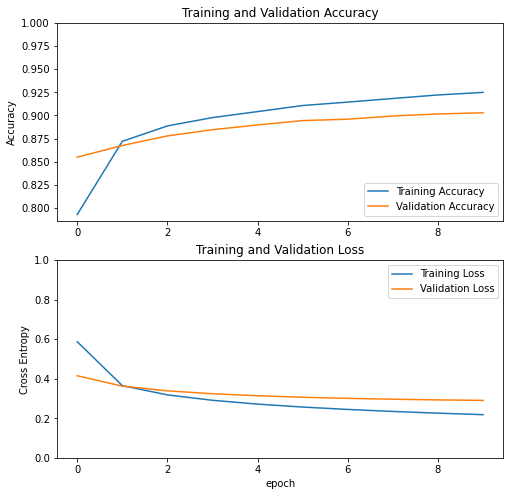

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# Efficientnetv2
## imagenet1k_b0

In [20]:
efficientnetv2="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
feature_extractor_model = efficientnetv2

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              5919312   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 5,926,998
Trainable params: 7,686
Non-trainable params: 5,919,312
_________________________________________________________________


In [24]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [25]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
506/506 [==============================] - 308s 589ms/step - loss: 0.6415 - acc: 0.7767 - val_loss: 0.4828 - val_acc: 0.8269
Epoch 2/10
506/506 [==============================] - 263s 520ms/step - loss: 0.4005 - acc: 0.8674 - val_loss: 0.3882 - val_acc: 0.8689
Epoch 3/10
506/506 [==============================] - 262s 517ms/step - loss: 0.3256 - acc: 0.8947 - val_loss: 0.3366 - val_acc: 0.8897
Epoch 4/10
506/506 [==============================] - 262s 517ms/step - loss: 0.2793 - acc: 0.9118 - val_loss: 0.3021 - val_acc: 0.9040
Epoch 5/10
506/506 [==============================] - 262s 518ms/step - loss: 0.2465 - acc: 0.9235 - val_loss: 0.2769 - val_acc: 0.9087
Epoch 6/10
506/506 [==============================] - 262s 518ms/step - loss: 0.2216 - acc: 0.9330 - val_loss: 0.2576 - val_acc: 0.9164
Epoch 7/10
506/506 [==============================] - 262s 517ms/step - loss: 0.2019 - acc: 0.9411 - val_loss: 0.2422 - val_acc: 0.9231
Epoch 8/10
506/506 [============================

Text(0.5, 0, 'epoch')

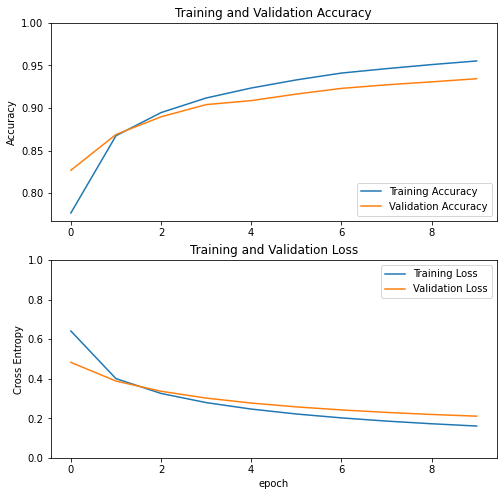

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# Resnet_50

In [27]:
resnet50="https://tfhub.dev/tensorflow/resnet_50/classification/1"
feature_extractor_model = resnet50

In [28]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [29]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [30]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              25612201  
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 6012      
Total params: 25,618,213
Trainable params: 6,012
Non-trainable params: 25,612,201
_________________________________________________________________


In [31]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [32]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
506/506 [==============================] - 995s 2s/step - loss: 1.6441 - acc: 0.5306 - val_loss: 1.5232 - val_acc: 0.5825
Epoch 2/10
506/506 [==============================] - 904s 2s/step - loss: 1.4249 - acc: 0.6234 - val_loss: 1.3477 - val_acc: 0.6478
Epoch 3/10
506/506 [==============================] - 900s 2s/step - loss: 1.2735 - acc: 0.6752 - val_loss: 1.2208 - val_acc: 0.6812
Epoch 4/10
506/506 [==============================] - 895s 2s/step - loss: 1.1623 - acc: 0.6989 - val_loss: 1.1257 - val_acc: 0.6992
Epoch 5/10
506/506 [==============================] - 895s 2s/step - loss: 1.0779 - acc: 0.7118 - val_loss: 1.0524 - val_acc: 0.7111
Epoch 6/10
506/506 [==============================] - 895s 2s/step - loss: 1.0120 - acc: 0.7214 - val_loss: 0.9943 - val_acc: 0.7168
Epoch 7/10
506/506 [==============================] - 894s 2s/step - loss: 0.9592 - acc: 0.7267 - val_loss: 0.9474 - val_acc: 0.7217
Epoch 8/10
506/506 [==============================] - 897s 2s/step - 

Text(0.5, 0, 'epoch')

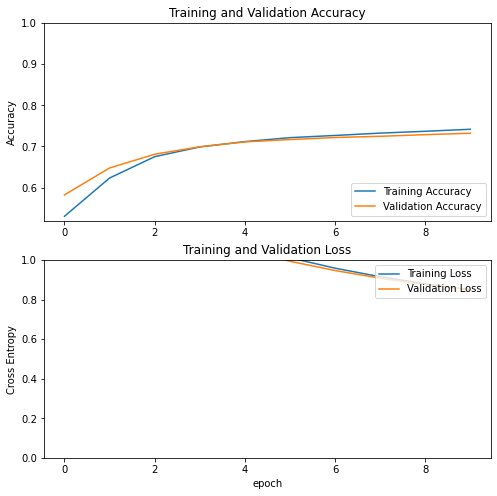

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# Inception_v3

In [34]:
batch_size = 32
img_height = 229
img_width = 229


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 20218 files belonging to 6 classes.
Using 16175 files for training.
Found 20218 files belonging to 6 classes.
Using 4043 files for validation.


In [35]:
class_names = np.array(train_ds.class_names)
print('class names for predictions :',class_names)

class names for predictions : ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


In [36]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 229, 229, 3)
(32,)


In [39]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
feature_extractor_model=inception_v3

In [40]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(229, 229, 3),
    trainable=False)

In [41]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [42]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6012      
Total params: 23,859,845
Trainable params: 6,012
Non-trainable params: 23,853,833
_________________________________________________________________


In [43]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [44]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
506/506 [==============================] - 555s 1s/step - loss: 0.7073 - acc: 0.7622 - val_loss: 0.5200 - val_acc: 0.8098
Epoch 2/10
506/506 [==============================] - 487s 964ms/step - loss: 0.4507 - acc: 0.8397 - val_loss: 0.4562 - val_acc: 0.8370
Epoch 3/10
506/506 [==============================] - 480s 949ms/step - loss: 0.3988 - acc: 0.8571 - val_loss: 0.4283 - val_acc: 0.8486
Epoch 4/10
506/506 [==============================] - 482s 952ms/step - loss: 0.3702 - acc: 0.8664 - val_loss: 0.4128 - val_acc: 0.8563
Epoch 5/10
506/506 [==============================] - 471s 932ms/step - loss: 0.3510 - acc: 0.8736 - val_loss: 0.4031 - val_acc: 0.8578
Epoch 6/10
506/506 [==============================] - 459s 908ms/step - loss: 0.3366 - acc: 0.8791 - val_loss: 0.3967 - val_acc: 0.8605
Epoch 7/10
506/506 [==============================] - 459s 907ms/step - loss: 0.3253 - acc: 0.8835 - val_loss: 0.3923 - val_acc: 0.8620
Epoch 8/10
506/506 [==============================]

Text(0.5, 0, 'epoch')

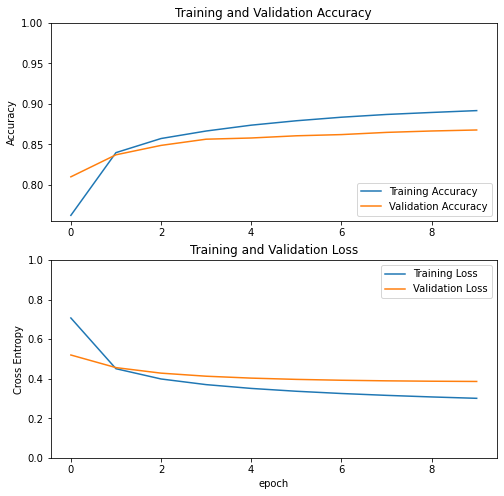

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')